In [1]:
from recom.datasets import load_ml_small_rating

# load data
dataset = load_ml_small_rating(need_raw=True)

# load features
ratings = dataset['raw']
ratings_train_dict = dataset['train_dict']
ratings_test_dict = dataset['test_dict']
n_user = dataset['n_user']
n_item = dataset['n_item']
user2ix = dataset['user2ix']
ix2user = dataset['ix2user']
item2ix = dataset['item2ix']
ix2item = dataset['ix2item']

del dataset

print(f'Users: {n_user}, Items: {n_item}. Sparsity: {round(1-len(ratings)/n_user/n_item, 4)}')
print(f'User reduced from {len(user2ix.keys())} to {len(ratings_train_dict.keys())}')

Users: 610, Items: 9724. Sparsity: 0.983
User reduced from 610 to 607


In [2]:
from torch import nn
from torch import Tensor, LongTensor


class ItemAutoEncoder(nn.Module):
    def __init__(self, n_user, hidden_dim=64
                     , encode_actv_func=nn.Sigmoid
                     , decode_actv_func=nn.Identity
                     , dropout=0.05) -> None:
        super(ItemAutoEncoder, self).__init__()
        # encoder: (n_user, hidden_dim)
        self.encoder = nn.Sequential(
            nn.Linear(n_user, hidden_dim, bias=True)
            , encode_actv_func()
        )
        # decoder: (hidden_dim, n_user)
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, n_user, bias=True)
            , decode_actv_func()
        )
        # dropout to reduce overfitting
        self.dropout = nn.Dropout(p=dropout)
        
    def pred(self, input):

        hidden = self.dropout(self.encoder(input))
        ratings = self.decoder(hidden)
        
        return ratings

    def forward(self, input):
        """ Only for training.
            We will use mask in this part to control gradients.
        """
        ratings = self.pred(input)
        # we contrain the output value to zero
        # , which, mathematically, can control the gradient of 
        # non-observed rating-related params to zero.
        mask = (input!=0)

        return ratings * mask


class UserAutoEncoder(nn.Module):
    def __init__(self, n_item, hidden_dim=64
                     , encode_actv_func=nn.Sigmoid
                     , decode_actv_func=nn.Identity
                     , dropout=0.05) -> None:
        super(UserAutoEncoder, self).__init__()
        # encoder: (n_user, hidden_dim)
        self.encoder = nn.Sequential(
            nn.Linear(n_item, hidden_dim, bias=True) # Only differs in input & output size
            , encode_actv_func()
        )
        # decoder: (hidden_dim, n_user)
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, n_item, bias=True) # Only differs in input & output size
            , decode_actv_func()
        )
        # dropout to reduce overfitting
        self.dropout = nn.Dropout(p=dropout)
        
    def pred(self, input):

        hidden = self.dropout(self.encoder(input))
        ratings = self.decoder(hidden)
        
        return ratings

    def forward(self, input):
        """ Same as Item based Auto Encoder.
        """
        ratings = self.pred(input)
        # we contrain the output value to zero
        # , which, mathematically, can control the gradient of 
        # non-observed rating-related params to zero.
        mask = (input!=0)

        return ratings * mask

In [5]:
def rating_vectorize(rat_dict, n_user, n_item, view='user'):
    from torch import zeros

    rat_mat = zeros(n_user, n_item)
    
    for u in rat_dict:
        for i in rat_dict[u]:
            rat_mat[u, i] = rat_dict[u][i]
    
    if view == 'item':
        return rat_mat.T
    else:
        return rat_mat

train_mat_i = rating_vectorize(ratings_train_dict, n_user=n_user, n_item=n_item ,view='item')
train_mat_u = rating_vectorize(ratings_train_dict, n_user=n_user, n_item=n_item ,view='user')

print(train_mat_i.shape, train_mat_u.shape)
train_mat_i

torch.Size([9724, 610]) torch.Size([610, 9724])


tensor([[0.0000, 0.0000, 0.0000,  ..., 2.5000, 3.0000, 5.0000],
        [0.0000, 0.0000, 0.0000,  ..., 2.0000, 0.0000, 0.0000],
        [4.0000, 0.0000, 0.0000,  ..., 2.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [6]:
def autorec_data_loader(rat_dict, n_user, n_item, view='item'
                        , use_sampling=False, obj_size=512
                        , batch_size=256):
    from torch.utils.data import DataLoader
    from random import choices
    from torch import LongTensor

    rating_mat = rating_vectorize(rat_dict, n_user, n_item, view)

    if use_sampling:
        by_axis = n_item if view=='item' else n_user
        rand_ixs = choices(list(range(by_axis)), obj_size)

        return DataLoader(dataset=rating_mat[LongTensor(rand_ixs)]
                          , batch_size=batch_size
                          , shuffle=True)
    else:
        return DataLoader(dataset=rating_mat, batch_size=batch_size, shuffle=True)

dl_i = autorec_data_loader(ratings_train_dict, n_user, n_item, view='item')
dl_u = autorec_data_loader(ratings_train_dict, n_user, n_item, view='user')

print(list(dl_i)[0].shape, list(dl_u)[0].shape)

torch.Size([256, 610]) torch.Size([256, 9724])


In [26]:
import time
from torch import autograd, LongTensor, device
from torch import optim
import numpy as np

def maskedSE(input:Tensor, target:Tensor):
    mask = (target!=0)

    return ((input[mask]-target[mask])**2)

def train_model(model, opt, view, rat_train, rat_test, use_cuda, n_epochs, report_interval):

    rating_mat = rating_vectorize(rat_train, n_user, n_item, view)
    test_mat = rating_vectorize(rat_test, n_user, n_item, view)


    if use_cuda:
        compute_device = device('cuda')
        model.cuda()
        rating_mat = rating_mat.to(compute_device)
        test_mat = test_mat.to(compute_device)
    else:
        compute_device = device('cpu')

    train_loss_by_ep = []
    test_rmse_by_ep = []

    t0 = time.time()
    for epoch in range(n_epochs):
        train_data = autorec_data_loader(rat_train, n_user, n_item, view)

        ep_loss = []
        for i, batch in enumerate(train_data):

            model.zero_grad()

            inputs = autograd.Variable(batch).to(compute_device)

            preds = model(inputs)
            loss = maskedSE(input=preds, target=inputs)
            loss.mean().backward()
            opt.step()
            ep_loss.extend(loss.data.to(compute_device).tolist())

        train_loss_by_ep.append(np.sqrt(np.mean(ep_loss)))
        
        # test
        preds = model.pred(rating_mat)
        test_rmse = maskedSE(preds, test_mat).mean().sqrt()
        test_rmse_by_ep.append(test_rmse.data.to(compute_device).tolist())

        if report_interval > 0 \
                and ((epoch+1) % report_interval == 0):
            
            t1=time.time()
            print(f'Epoch: {epoch+1}, Time: {round(t1-t0,2)},  /Average train loss {round(sum(train_loss_by_ep[-report_interval:])/report_interval, 5)}')
            print(f'\t\t\t/Average test loss {round(sum(test_rmse_by_ep[-report_interval:])/report_interval, 5)}')
            t0=time.time()

    model = model.to('cpu') # send to cpu anyway
    
    return model, train_loss_by_ep, test_rmse_by_ep


USE_CUDA = True
N_EPOCHS = 32
REPORT_INTERVAL=6

""" 1. user-based auto encoder """
iar = ItemAutoEncoder(n_user, hidden_dim=128)
iar_opt = optim.Adam(iar.parameters(), lr=0.0005, weight_decay=1e-4)
# train model
iar, iar_train_loss_by_ep, iar_test_rmse_by_ep = train_model(
    iar, iar_opt, 'item'
    , ratings_train_dict, ratings_test_dict
    , USE_CUDA, N_EPOCHS, REPORT_INTERVAL
)

""" 2. item-based auto encoder """
uar = UserAutoEncoder(n_item, hidden_dim=128)
uar_opt = optim.Adam(uar.parameters(), lr=0.005, weight_decay=1e-5)
# train model
uar, uar_train_loss_by_ep, uar_test_rmse_by_ep = train_model(
    uar, uar_opt, 'user'
    , ratings_train_dict, ratings_test_dict
    , USE_CUDA, N_EPOCHS, REPORT_INTERVAL
)

Epoch: 6, Time: 6.3,  /Average train loss 1.46173
			/Average test loss 1.22853
Epoch: 12, Time: 5.22,  /Average train loss 0.93296
			/Average test loss 0.8509
Epoch: 18, Time: 4.8,  /Average train loss 0.86834
			/Average test loss 0.78966
Epoch: 24, Time: 4.48,  /Average train loss 0.83167
			/Average test loss 0.77054
Epoch: 30, Time: 4.68,  /Average train loss 0.80161
			/Average test loss 0.76876
Epoch: 6, Time: 3.11,  /Average train loss 1.83371
			/Average test loss 1.59055
Epoch: 12, Time: 3.07,  /Average train loss 0.96357
			/Average test loss 1.14392
Epoch: 18, Time: 2.96,  /Average train loss 0.87758
			/Average test loss 1.05618
Epoch: 24, Time: 3.07,  /Average train loss 0.84896
			/Average test loss 1.05824
Epoch: 30, Time: 3.82,  /Average train loss 0.83065
			/Average test loss 1.05582


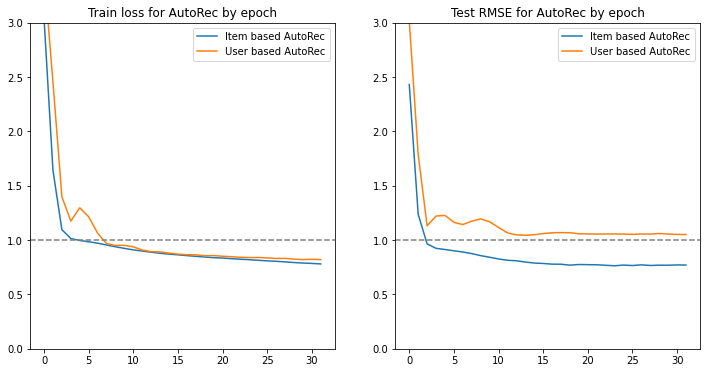

In [35]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Cut your window in 1 row and 2 columns, and start a plot in the first part
plt.subplot(121)
plt.plot(list(range(N_EPOCHS)), iar_train_loss_by_ep)
plt.plot(list(range(N_EPOCHS)), uar_train_loss_by_ep)
plt.axhline(y=1, color='grey', linestyle='--')
plt.legend(['Item based AutoRec', 'User based AutoRec'])
plt.title("Train loss for AutoRec by epoch")
plt.ylim([0,3])

# And now add something in the second part:
plt.subplot(122)
plt.plot(list(range(N_EPOCHS)), iar_test_rmse_by_ep)
plt.plot(list(range(N_EPOCHS)), uar_test_rmse_by_ep) 
plt.axhline(y=1, color='grey', linestyle='--')
plt.legend(['Item based AutoRec', 'User based AutoRec'])
plt.title("Test RMSE for AutoRec by epoch")
plt.ylim([0,3])

# Show the graph
plt.show()